# Predicting NBA Player Points per Game based on Player Characteristics

# Introduction

Basketball is a sport that requires one team to score more points than the other team in order to win (Logan). Consequently, players that score more points per game tend to have a higher impact and value than those that do not. Many variables can affect a player’s ability to score (Greenberg), and in this project, we will explore a basketball dataset of NBA players in order to answer the following prediction-focused question:

**How well does an NBA player's years of experience, height, and division predict his points per game?**

The data used was obtained from a table called *Player_Attributes* in an SQLite database on Kaggle called *Basketball Dataset*. This database is updated daily and contains data on all games, all teams, and all players within the NBA; the table we have chosen describes the characteristics of an NBA player, including their physical characteristics (height and weight), basketball statistics, and previous experience. We will be using the following input and response variables.

- `PTS` (Response): Points per game
- `HEIGHT` (Input): height in inches
- `SEASON_EXP` (Input): season/years played
- `DIVISION` (Input, not part of initial dataset): team division

The average height of an NBA player has increased over the years, and this is associated with increased field-goal percentage, indicating that there may also be an association with points per game as players have begun to score more efficiently. Additionally, older players tend to be more savvy, knowledgeable and understand how to manipulate the rules of basketball, meaning that there could be a positive association between years played and points per game. Lastly, we would also like to explore the association between division and points per game, as different regions have different climates and elevations that may impact a player's fitness and overall ability to score points.

# Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(broom)
library(leaps)
library(mltools)
library(cowplot)
library(GGally)
library(glmnet)
library(caret)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-3

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘reshape2

In [2]:
# loading the data
basketball_data <- read_csv("data/Player_Attributes.csv")

"Table 1: Initial Dataset"
head(basketball_data)

Rows: 4500 Columns: 37

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (24): FIRST_NAME, LAST_NAME, DISPLAY_FIRST_LAST, DISPLAY_LAST_COMMA_FIR...
dbl  (12): ID, HEIGHT, WEIGHT, SEASON_EXP, TEAM_ID, FROM_YEAR, TO_YEAR, PTS,...
dttm  (1): BIRTHDATE


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Table 1: Initial Dataset"

ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,⋯,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24,Duke,USA,⋯,Y,Y,1990,1,25,5.7,0.3,3.3,0,NA
76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07,Iowa State,USA,⋯,Y,Y,1968,1,5,9.0,1.2,8.0,0,NA
76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16,UCLA,USA,⋯,Y,Y,1969,1,1,24.6,3.6,11.2,18,NA
51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09,Louisiana State,USA,⋯,Y,Y,1990,1,3,14.6,3.5,1.9,0,NA
1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03,San Jose State,France,⋯,Y,Y,1997,1,11,7.8,1.1,3.3,0,NA
949,Shareef,Abdur-Rahim,Shareef Abdur-Rahim,"Abdur-Rahim, Shareef",S. Abdur-Rahim,shareef-abdur-rahim,1976-12-11,California,USA,⋯,Y,Y,1996,1,3,18.1,2.5,7.5,1,NA


To get the dataset we want to work with, we first tidy the data to filter out unnecessary columns. Then, we classify teams in their respective divisions from ESPN's current NBA standings.

In [3]:
# selecting the relevant explanatory and response variables
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, TEAM_NAME, PTS) %>%
        filter(!is.na(TEAM_NAME)) %>%
        filter(!is.na(SEASON_EXP)) %>%
        filter(!is.na(HEIGHT)) %>%
        filter(!is.na(PTS))

# classifying teams into their respective divisions from ESPN's current NBA standings
southwest <- c("Rockets", "Grizzlies", "Spurs", "Mavericks", "Mavericks")
pacific <- c("Lakers", "Clippers", "Kings", "Suns", "Royals", "Braves", "Warriors")
northwest <- c("Jazz", "Nuggets", "Timberwolves", "SuperSonics", "Trail Blazers", "Thunder")
southeast <- c("Wizards", "Hornets", "Hawks", "Falcons", "Blackhawks", "Bobcats", "Bullets", "Heat", "Magic")
central <- c("Bulls", "Bucks", "Pistons", "Pacers", "Cavaliers")
atlantic <- c("Knicks", "Nets", "Raptors", "76ers", "Nationals", "Celtics")

basketball_data <- basketball_data %>% mutate(DIVISION = case_when(TEAM_NAME %in% southwest ~ "Southwest",
                                                                   TEAM_NAME %in% pacific ~ "Pacific",
                                                                   TEAM_NAME %in% northwest ~ "Northwest",
                                                                   TEAM_NAME %in% southeast ~ "Southeast",
                                                                   TEAM_NAME %in% central ~ "Central",
                                                                   TEAM_NAME %in% atlantic ~ "Atlantic",
                                                                   TRUE ~ "ND"))

# Checking to find team names that haven't been classified yet
basketball_nd <- filter(basketball_data, DIVISION == "ND") %>%
group_by(TEAM_NAME) %>%
summarize(mean = mean(SEASON_EXP))
print(basketball_nd$TEAM_NAME)

# Omitting unclassified rows
basketball_data <- basketball_data %>%
    filter(!TEAM_NAME %in% c("Bombers", "Capitols", "Huskies", "Ironmen", "Jets", "Olympians", "Packers", "Rebels", "Redskins", "Stags", "Steamrollers", "Zephyrs"))

 [1] "Bombers"      "Capitols"     "Huskies"      "Ironmen"      "Jets"        
 [6] "Olympians"    "Packers"      "Pelicans"     "Rebels"       "Redskins"    
[11] "Stags"        "Steamrollers" "Zephyrs"     


## Tidied Dataset

In [4]:
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, PTS, DIVISION)

"Table 2: Tidied Dataset"
head(basketball_data)

[1] "Table 2: Tidied Dataset"

SEASON_EXP,HEIGHT,PTS,DIVISION
<dbl>,<dbl>,<dbl>,<chr>
4,82,5.7,Northwest
9,81,9.0,Southwest
19,86,24.6,Pacific
8,73,14.6,Northwest
6,78,7.8,Pacific
12,81,18.1,Southwest


Using the tidied data, we use `ggpairs` to look for any association between pairs of variables. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



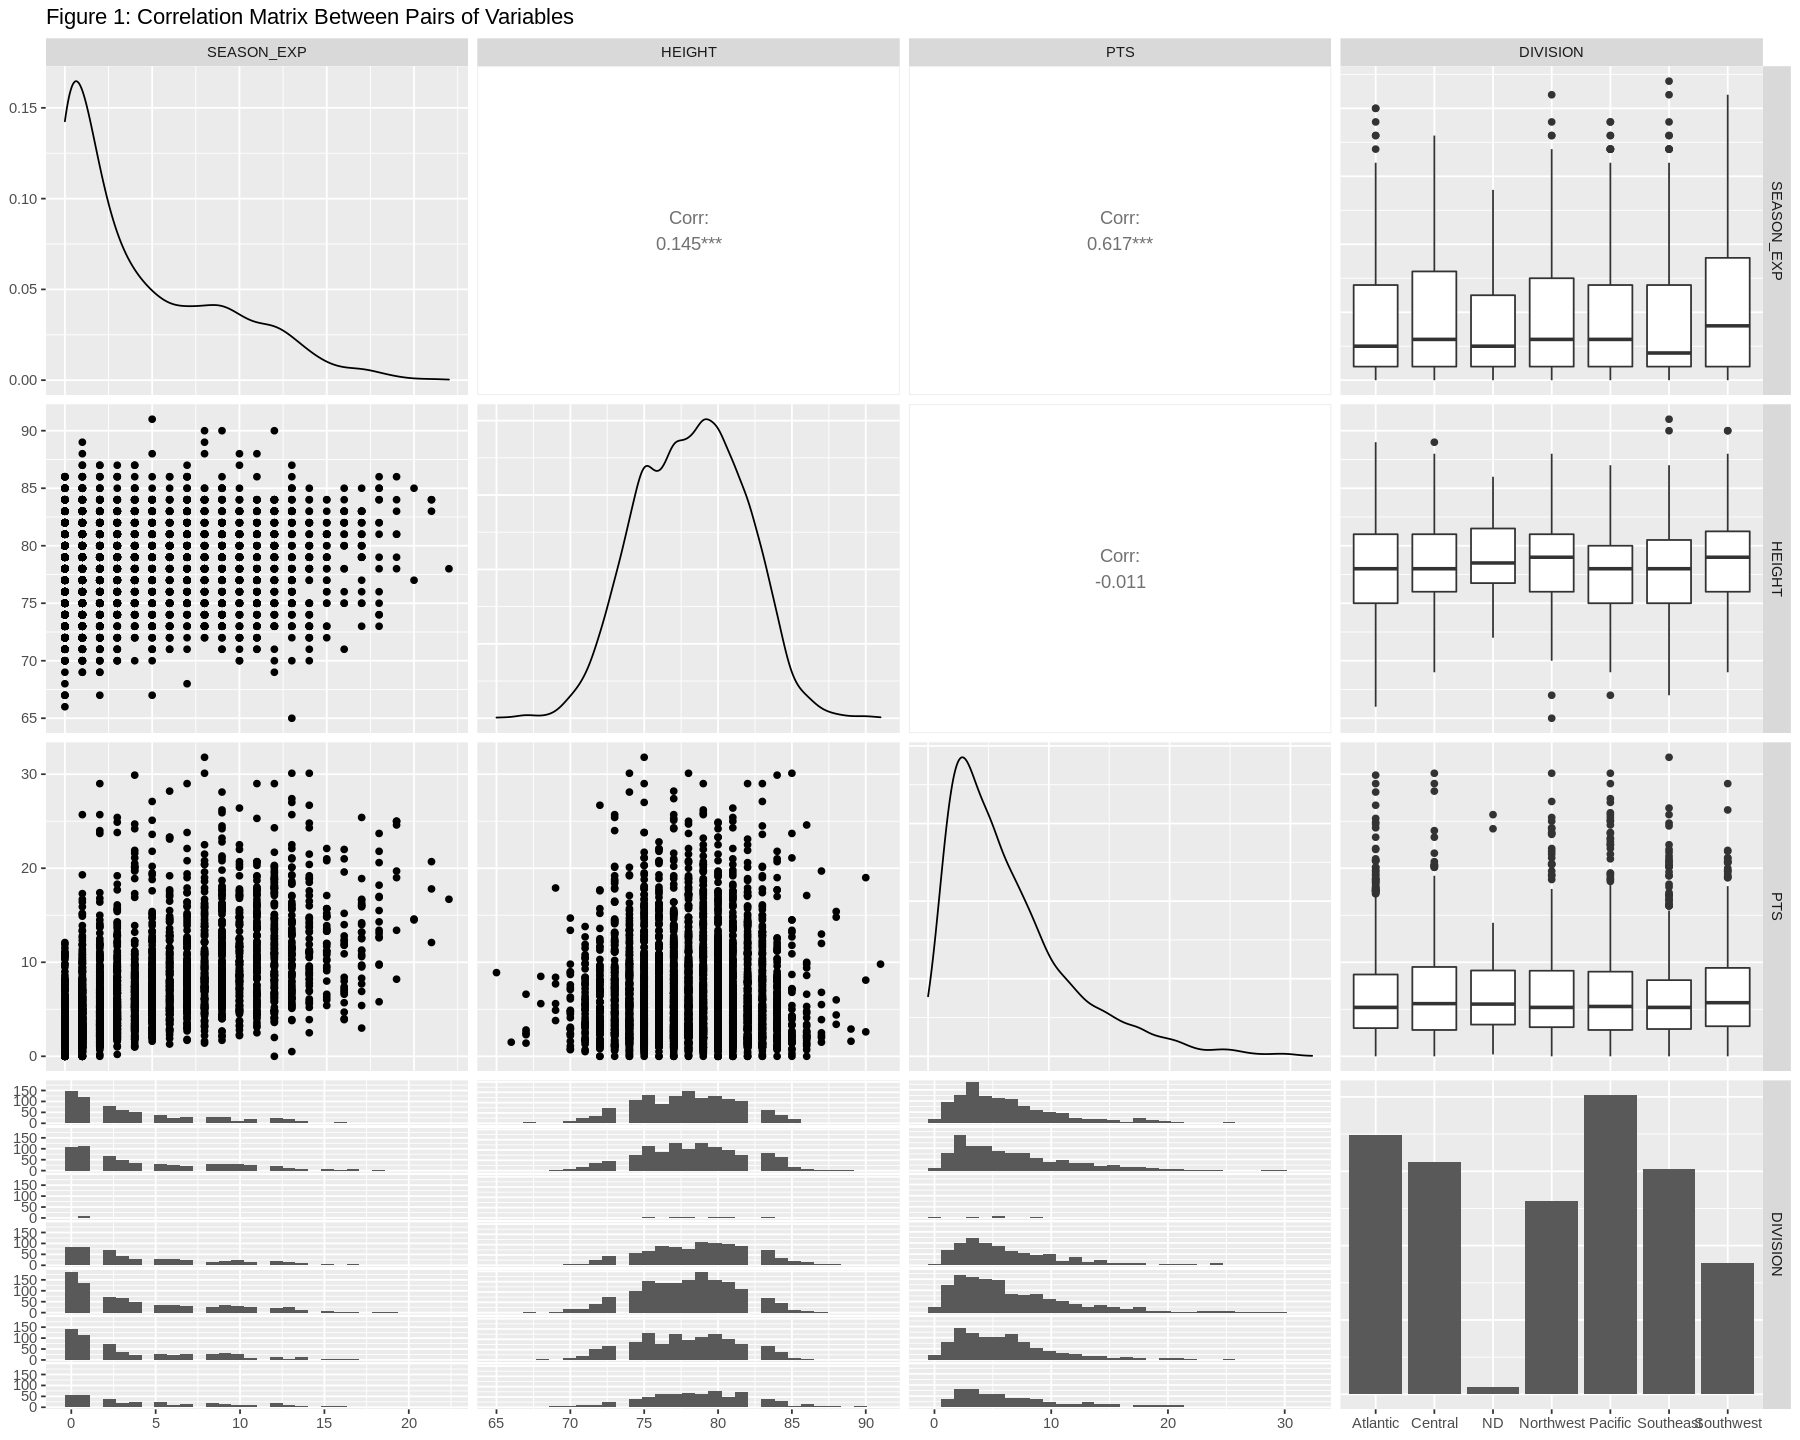

In [5]:
options(repr.plot.width = 15, repr.plot.height = 12)
ggpairs(basketball_data) +
    ggtitle("Figure 1: Correlation Matrix Between Pairs of Variables")

In [6]:
# Plotting the divisions against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_division_data <- basketball_data %>%
    group_by(DIVISION) %>%
    summarize(mean_PTS = mean(PTS))

bb_division_plot <- ggplot(bb_division_data, aes(x = DIVISION, y = mean_PTS)) +
  geom_point(size = 2) +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "NBA Division", y = "Points per Game", title = "Figure 2: Division vs. PTS Plot")

In [7]:
# Plotting the heights against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_height_data <- basketball_data %>%
    group_by(HEIGHT) %>%
    summarize(mean_PTS = mean(PTS))

bb_height_plot <- ggplot(bb_height_data, aes(x = HEIGHT, y = mean_PTS)) +
  geom_point(size = 2) +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Height (inches)", y = "Points per Game", title = "Figure 3: Height vs. PTS Plot")

In [8]:
# Plotting the years of experience against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_exp_data <- basketball_data %>%
    group_by(SEASON_EXP) %>%
    summarize(mean_PTS = mean(PTS))

bb_exp_plot <- ggplot(bb_exp_data, aes(x = SEASON_EXP, y = mean_PTS)) +
  geom_point(size = 2) +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Years of Experience", y = "Points per Game", title = "Figure 4: Experience vs. PTS Plot")

We plot the above 3 plots side-by-side for easier comparision.

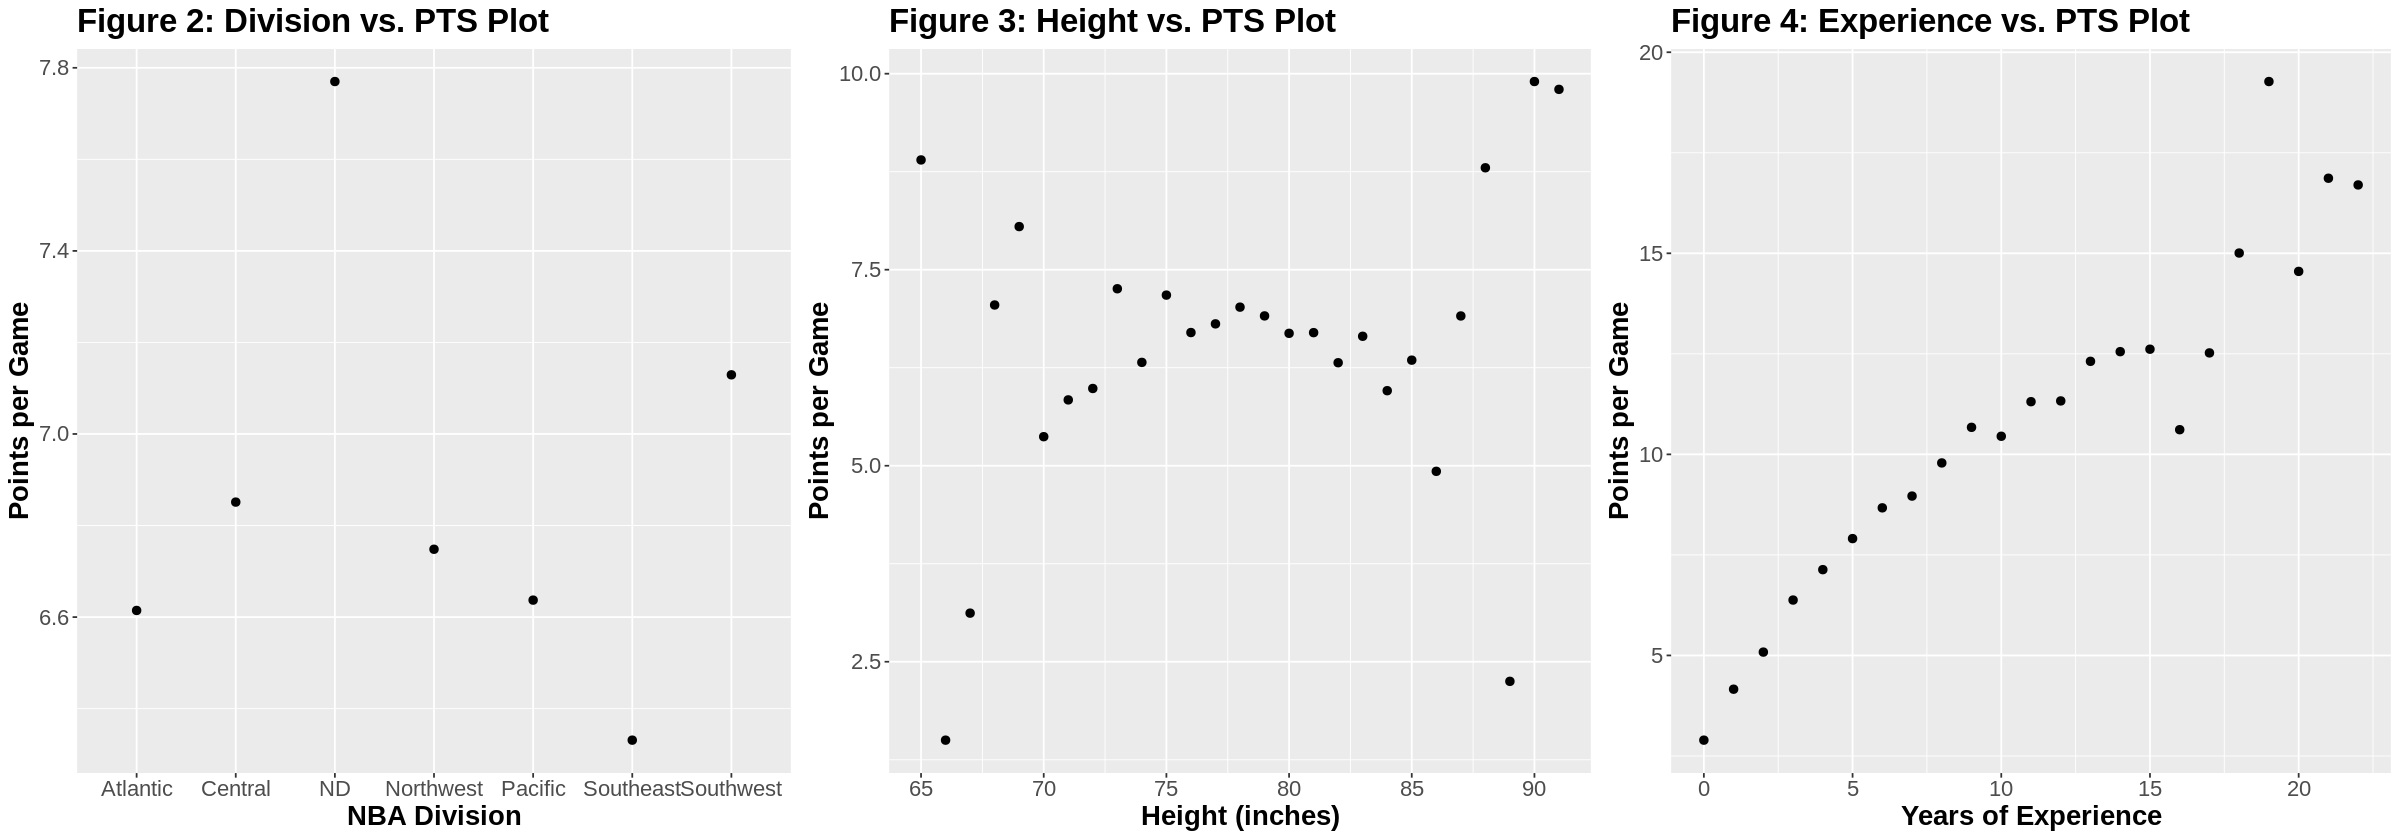

In [9]:
options(repr.plot.width = 20, repr.plot.height = 7)
eda_3_plot <- plot_grid(bb_division_plot, bb_height_plot, bb_exp_plot, ncol = 3)
eda_3_plot

From Figure 2, we can see that the division with the highest amount of points per game is the Southwest division followed by Central, Northwest, and so on. 

In Figure 3, we see that a majority of the heights are between 70 and 85 inches, with points per game ranging from 5 to 7.5. With that being said, those with a height of less than 70 inches or those with heights of greater than 85 have a range of 1.25 to 10 points.

And in Figure 4, there is, generally, an increasing trend where an increase in the years of experience is associated with an increase of points per game.

# Methods and Results

To build our predictive model, we split our dataset into 2 types: a training set and a testing set, where 70% of the data is dedicated for the training set and 30% for the testing set.

In [10]:
set.seed(20211121)
basketball_data <- basketball_data %>% mutate(ID = row_number())
basketball_training <- basketball_data %>% slice_sample(prop = 0.7)
basketball_testing <- basketball_data %>% anti_join(basketball_training)

basketball_training <- basketball_training %>% select(-ID)
basketball_testing <- basketball_testing %>% select(-ID)

Joining, by = c("SEASON_EXP", "HEIGHT", "PTS", "DIVISION", "ID")



Before performing $k$-fold cross-validation (CV) with 5 and 10 folds, we define the training control models for 5 and 10 folds. Because the data set is split, we use $k$-fold cross-validation to avoid overestimation and high variability of the population test error rate.

In [11]:
train_control_5 <- trainControl(method="cv", number = 5)
train_control_10 <- trainControl(method="cv", number = 10)

## Model Assessment

Now, we perform 5-fold and 10-fold cross-validation on both additive and interactive models to see which model has the lowest RMSE.

In [12]:
# Additive model
model_5CV_add <- train(PTS~., data = basketball_training, 
               trControl=train_control_5, method="lm")
model_10CV_add <- train(PTS~., data = basketball_training, 
               trControl=train_control_10, method="lm")

# Interactive model
model_5CV_interact <- train(PTS~SEASON_EXP * HEIGHT * DIVISION, data = basketball_training, 
               trControl=train_control_5, method="lm")
model_10CV_interact <- train(PTS~SEASON_EXP * HEIGHT * DIVISION, data = basketball_training, 
               trControl=train_control_10, method="lm")

A summary of the RMSE from each model are as follows:

Table 3: Summary of 5 and 10-fold CV and their RMSE

|Model | RMSE |
|---|---|
| 5-fold additive | 3.954449 | 
| 10-fold additive | 3.953139 |
| 5-fold interactive | 3.980829 |
| 10-fold interactive | 3.961033 |

## Model Selection

We see that 10-fold additive model has the lowest RMSE of 3.953139, and, thus, is the best model to use in building our predictive model.

A new column is added to `basketball_testing` for the predicted number of points, based on our new model.

In [13]:
basketball_predicted <- basketball_testing %>% mutate(predict = predict(model_10CV_add, newdata=.))

'Table 4: Dataset with Model Prediction'
head(basketball_predicted)

[1] "Table 4: Dataset with Model Prediction"

SEASON_EXP,HEIGHT,PTS,DIVISION,predict
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
9,81,9.0,Southwest,9.690484
4,79,5.6,Pacific,6.218144
0,75,0.0,Atlantic,4.346686
2,77,2.7,Pacific,5.123135
5,83,3.6,Southeast,6.074024
2,77,3.2,Southwest,5.438896


Here, we get the RMSE of our chosen model using 10-fold cross-validation by comparing it to the testing set, `basketball_testing` created at the beginning.

In [14]:
rmse <- rmse(preds = basketball_predicted$predict, actuals = basketball_predicted$PTS)
rmse

[1] 4.030258

The RMSE (ie: prediction performance) of our predictive model is 4.03327870304258, or 4, points. 

## Comparison Plots

Here, we overlay the new model's predictions onto the original data set, `basketball_data`, to visualize the performance of our model. 

### Height vs. Points

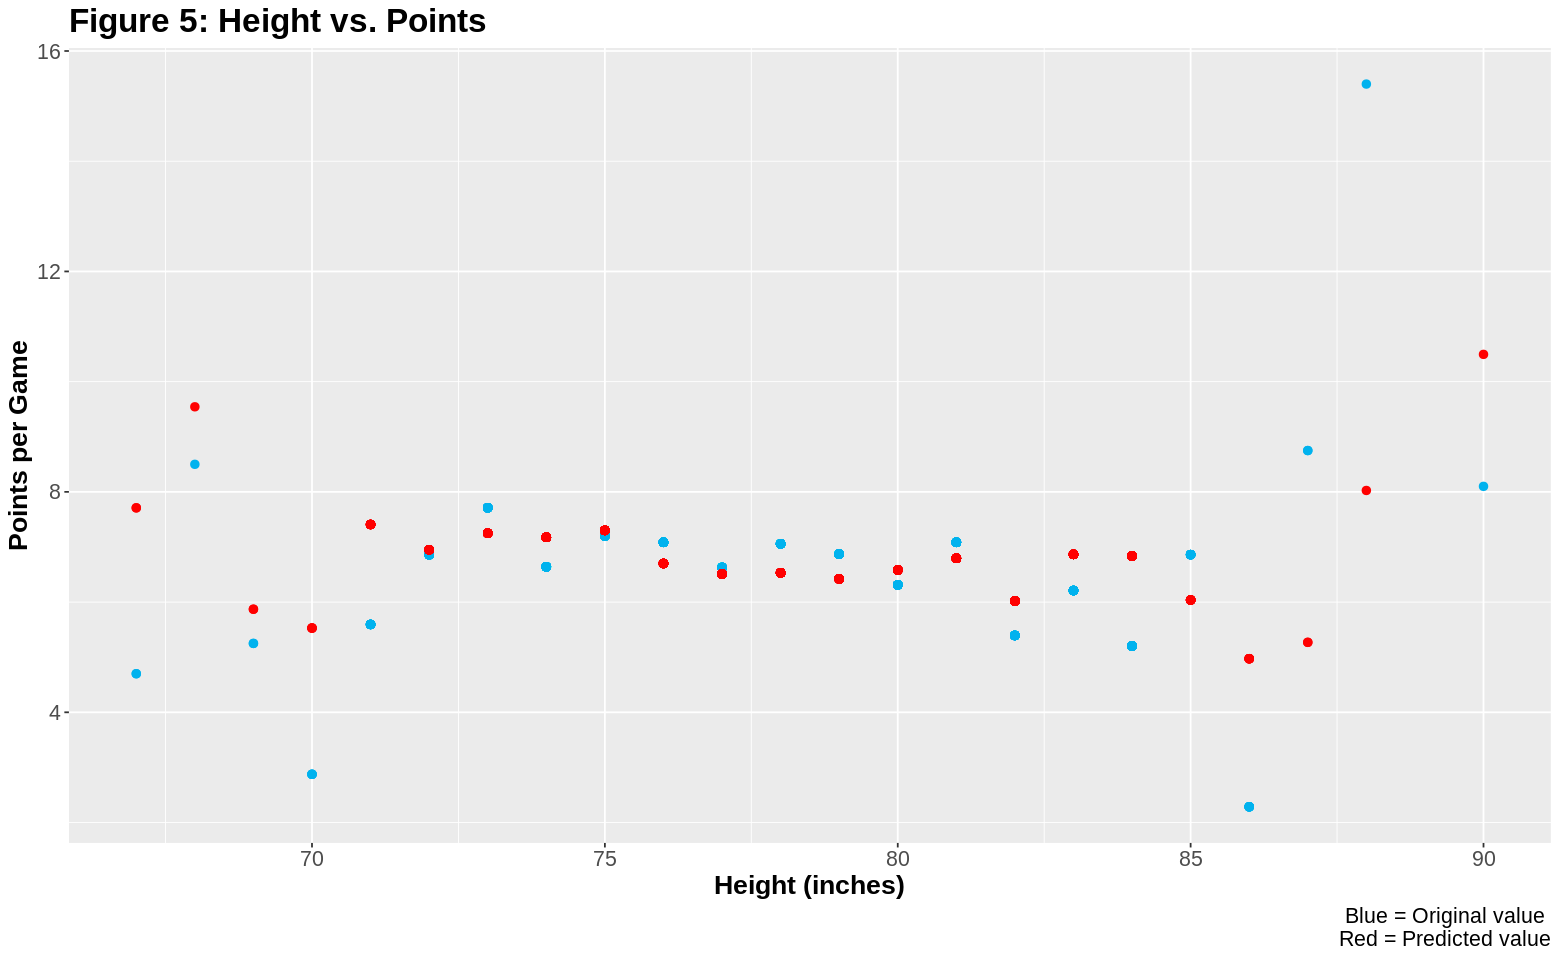

In [15]:
options(repr.plot.width = 13, repr.plot.height = 8)
height_odf <- basketball_predicted %>% group_by(HEIGHT) %>% mutate(mean_pts = mean(PTS))
height_mdf <- basketball_predicted %>% group_by(HEIGHT) %>% mutate(mean_pred = mean(predict))

height_plot <- ggplot() +
    geom_point(data=height_odf, aes(x = HEIGHT, y = mean_pts), size = 2, color = "deepskyblue2") +
    geom_point(data=height_mdf, aes(x = HEIGHT, y = mean_pred), size = 2, color = "red") +
    labs(x = "Height (inches)", y = "Points per Game", 
         title = "Figure 5: Height vs. Points",
         caption = "Blue = Original value \n Red = Predicted value") +
      theme(
        text = element_text(size = 16),
        plot.title = element_text(face = "bold", size = 20),
        axis.title = element_text(face = "bold")
      )
height_plot

We see that our model predicts some values quite closely to the original values in the data set, with it tending to predict higher than the original values. 

To better see the difference between our model and the original values, the table below shows the points in the original data set (`mean_pts`), the points predicted from our model (`mean_pred`), and their difference (`diff`), arranged in ascending order by height. 

In [16]:
height_sum1 <- height_odf %>% select(HEIGHT, mean_pts) %>% arrange(HEIGHT) %>% unique()
height_sum2 <- height_mdf %>% select(HEIGHT, mean_pred) %>% arrange(HEIGHT) %>% unique()

height_sum <- height_sum1 %>% cbind(mean_pred = height_sum2$mean_pred) %>% mutate(diff = mean_pred-mean_pts)
'Table 5: Summary of the Difference in Points, With Respect to Height'
height_sum

[1] "Table 5: Summary of the Difference in Points, With Respect to Height"

HEIGHT,mean_pts,mean_pred,diff
<dbl>,<dbl>,<dbl>,<dbl>
67,4.700000,7.710061,3.01006071
68,8.500000,9.543696,1.04369591
69,5.250000,5.870593,0.62059322
70,2.875000,5.528902,2.65390209
71,5.594118,7.408111,1.81399374
72,6.858333,6.949228,0.09089433
73,7.711905,7.249986,-0.46191836
74,6.640000,7.176026,0.53602625
75,7.200990,7.301310,0.10031970


As shown in the graph, the heights with the largest discrepancy between the original data set and our predictive model are: 67, 70, 86, 87, 88, and 90 inches, with a height of 88 inches having the largest different of 7.32801564. 

This is probably because there are only 4 rows in the training data set in which our predictive model can train on whereas when height is 75 inches, there are 229 rows the predictive model can train on. Moreover, it might be caused by the non-linear relationship between height and points.

### Division vs. Points

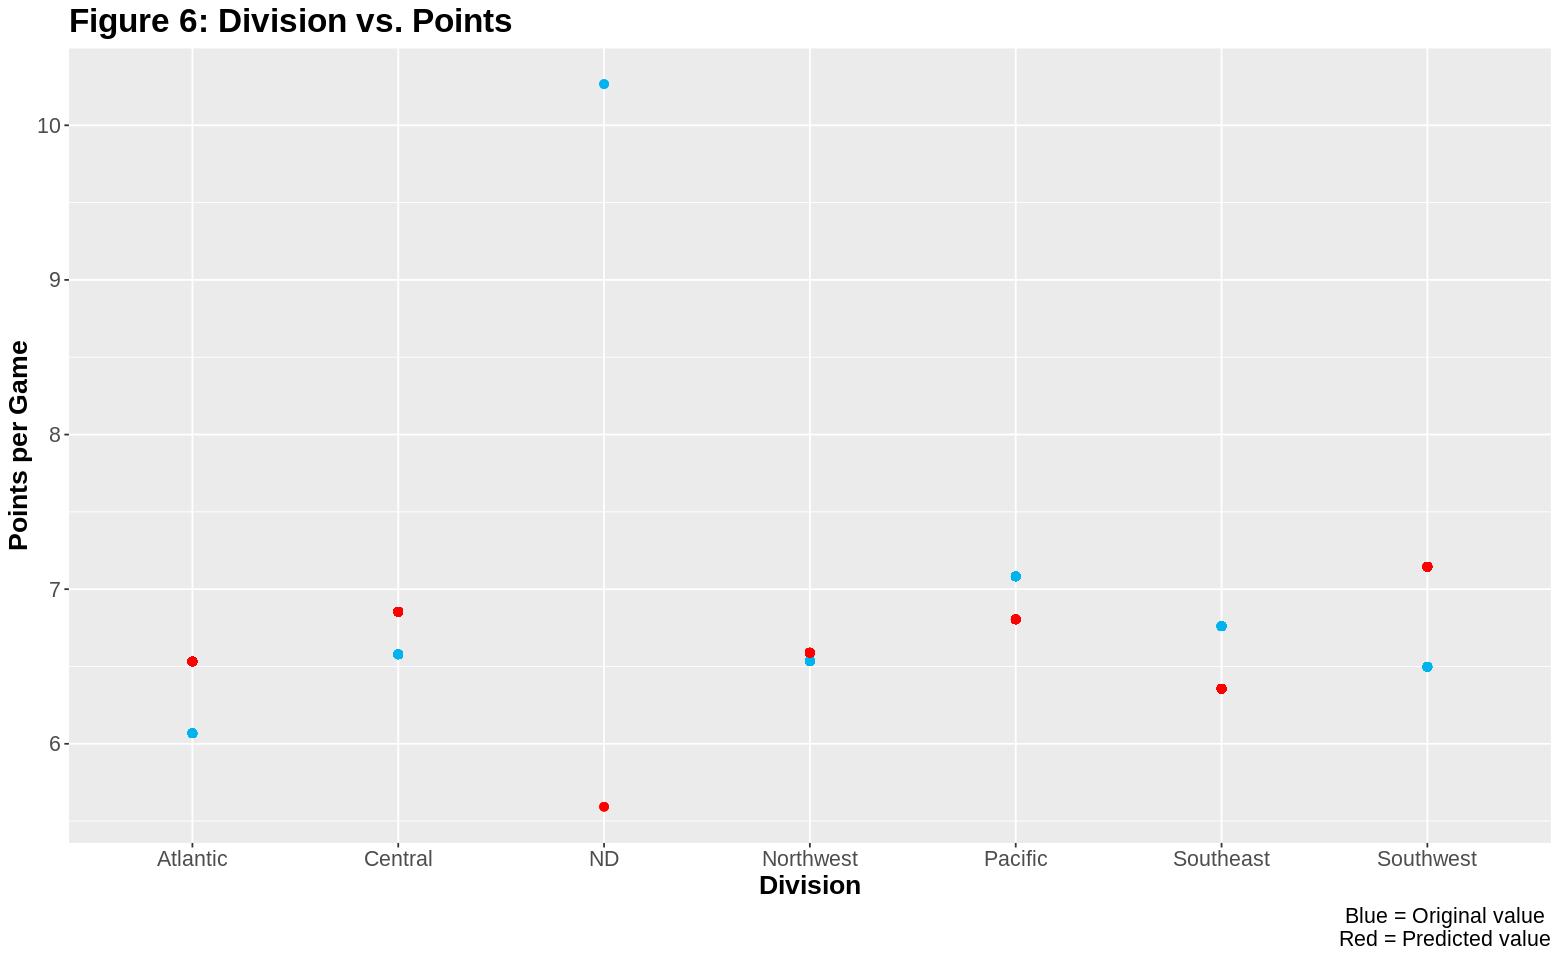

In [17]:
dvsn_odf <- basketball_predicted %>% group_by(DIVISION) %>% mutate(mean_pts = mean(PTS))
dvsn_mdf <- basketball_predicted %>% group_by(DIVISION) %>% mutate(mean_pred = mean(predict))

dvsn_plot <- ggplot() +
    geom_point(data=dvsn_odf, aes(x = DIVISION, y = mean_pts), size = 2, color = "deepskyblue2") +
    geom_point(data=dvsn_mdf, aes(x = DIVISION, y = mean_pred), size = 2, color = "red") +
    labs(x = "Division", y = "Points per Game", 
         title = "Figure 6: Division vs. Points",
         caption = "Blue = Original value \n Red = Predicted value") +
      theme(
        text = element_text(size = 16),
        plot.title = element_text(face = "bold", size = 20),
        axis.title = element_text(face = "bold")
      )
dvsn_plot

Upon first glance, the graphical representation shows that our model is either significantly over or under predicting the number of points per game, because of the scale. However, when looking at the table below, the difference between the actual and predicted values is less than 1 point. 

In [18]:
dvsn_sum1 <- dvsn_odf %>% select(DIVISION, mean_pts) %>% unique()
dvsn_sum2 <- dvsn_mdf %>% select(DIVISION, mean_pred) %>% unique()

dvsn_sum <- dvsn_sum1 %>% cbind(mean_pred = dvsn_sum2$mean_pred) %>% mutate(diff = mean_pred-mean_pts)
'Table 6: Summary of the Difference in Points, With Respect to Division'
dvsn_sum

[1] "Table 6: Summary of the Difference in Points, With Respect to Division"

DIVISION,mean_pts,mean_pred,diff
<chr>,<dbl>,<dbl>,<dbl>
Southwest,6.497541,7.145264,0.64772281
Pacific,7.082500,6.804504,-0.27799645
Atlantic,6.068224,6.532276,0.46405167
Southeast,6.760736,6.356116,-0.40462029
Central,6.578307,6.853641,0.27533457
Northwest,6.533758,6.589258,0.05549967
ND,10.266667,5.592673,-4.67399353


### Season Experience vs. Points

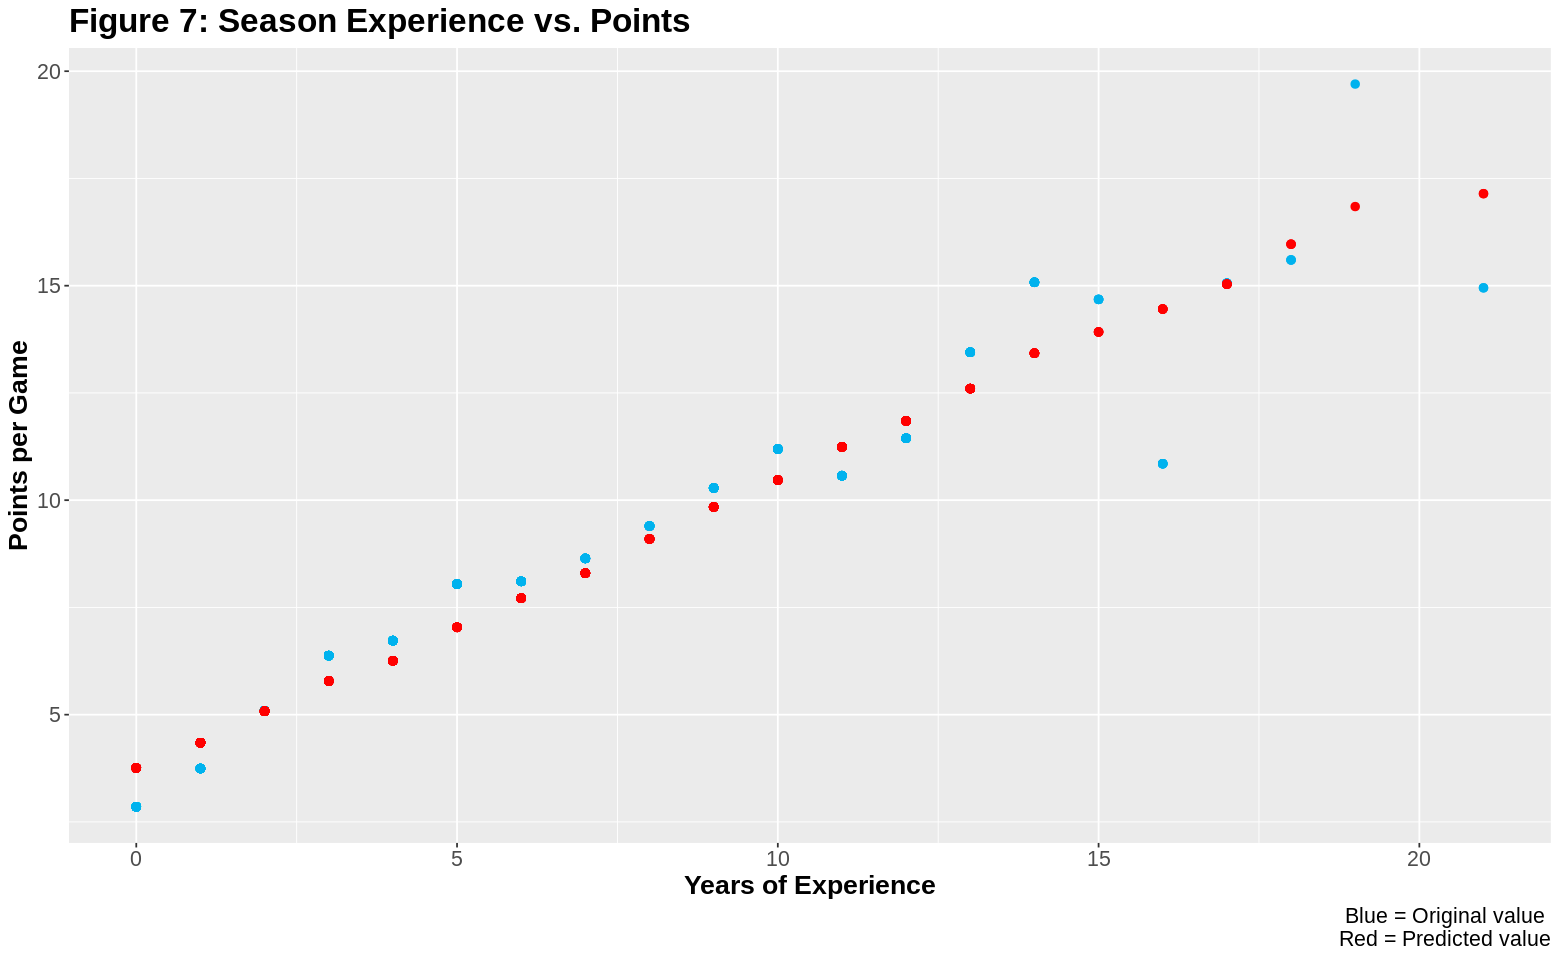

In [19]:
sxp_odf <- basketball_predicted %>% group_by(SEASON_EXP) %>% mutate(mean_pts = mean(PTS))
sxp_mdf <- basketball_predicted %>% group_by(SEASON_EXP) %>% mutate(mean_pred = mean(predict))

sxp_plot <- ggplot() +
    geom_point(data=sxp_odf, aes(x = SEASON_EXP, y = mean_pts), size = 2, color = "deepskyblue2") +
    geom_point(data=sxp_mdf, aes(x = SEASON_EXP, y = mean_pred), size = 2, color = "red") +
    labs(x = "Years of Experience", y = "Points per Game", 
         title = "Figure 7: Season Experience vs. Points",
         caption = "Blue = Original value \n Red = Predicted value") +
      theme(
        text = element_text(size = 16),
        plot.title = element_text(face = "bold", size = 20),
        axis.title = element_text(face = "bold")
      )
sxp_plot

Our model here predicts the number of points closely to the actual values in `basketball_data`. We see that the model predicts values in such a way that it imitates a simple line with a positive slope.

Again, the numerical representation is displayed below, to see the exact numbers. 

In [20]:
sxp_sum1 <- sxp_odf %>% select(SEASON_EXP, mean_pts) %>% arrange(SEASON_EXP) %>% unique()
sxp_sum2 <- sxp_mdf %>% select(SEASON_EXP, mean_pred) %>% arrange(SEASON_EXP) %>% unique()

sxp_sum <- sxp_sum1 %>% cbind(mean_pred = sxp_sum2$mean_pred) %>% mutate(diff = mean_pred-mean_pts)
'Table 7: Summary of the Difference in Points, With Respect to Season Experience'
sxp_sum

[1] "Table 7: Summary of the Difference in Points, With Respect to Season Experience"

SEASON_EXP,mean_pts,mean_pred,diff
<dbl>,<dbl>,<dbl>,<dbl>
0,2.852683,3.757657,0.904973956
1,3.744444,4.345485,0.601040994
2,5.091597,5.082414,-0.009182683
3,6.376190,5.784185,-0.592005292
4,6.726230,6.256829,-0.469400565
5,8.043103,7.035835,-1.007268403
6,8.107407,7.714570,-0.392837593
7,8.642105,8.298393,-0.343712219
8,9.397561,9.095121,-0.302439670


Notably, when the years of experience are 14, 16, 19, and 21, the model predicts the worst. Following the same reasoning as before in section [Height vs. Points](#Height-vs.-Points), there are few instances of said years of experience in the training data set which the predictive model can train on. Therefore, when predicting 14, 16, 19, and 21 years of experience, the model adapts the linear trend from years of experience that are lesser than that.

# Discussion

The RMSE was found to be the lowest in the 10-fold additive model, indicating that this was the best model to use when predicting on the training data. For height and years of experience, the general trend was such that the model was good at predicting the lower values and the residuals increase as the value of the explanatory variable increases. This model would be extremely useful for NBA teams when trading and making contracts with players. Based on the expected aptitude of the player, they can make decisions on how long the contract should be or how much the player’s salary should be, for instance. An interesting thing to consider would be the significance of this model in the NBA drafting process, since we know it can provide insight into an existing player’s abilities, but can it do the same for a new player? There could be experienced players who just don’t have season experience, but have still been playing professionally for a long time, compared to a newly drafted player. However, our model would classify both said players into 0 years of season experience, so it is contentious if the model can predict newly drafted players’ points per game as well as it can for someone who has still been playing pro basketball for a while but without season experience.

The training set RMSE was found to be lower than the test RMSE, and this was to be expected because the model was overfitted for the training set and hasn’t seen the data from the test set. However, it was interesting to discover that the best model for predicting was an additive model rather than an interaction model, and this is because one would expect some amount of even coincidental, if not intended, interaction between the input variables. It could be very possible that taller players or more experienced players happen to be in certain divisions because teams of those divisions have more funding or financial means to bid for the players. It’s however a pleasant surprise to see that an additive model fits better than an interaction model, since that makes it easier to generate distinct models with other input variables to predict a player’s points per game.

The model could be improved by creating separate predictive models for different eras (periods) of NBA basketball. While this could create bias, the data could still be randomized with the random selection of players from each era to compose the corresponding datasets. In having separate models, the resulting predictions would likely be more accurate, as they would not be affected by the extreme variability noticeable in different time periods. This variability stems from rule changes throughout the years that have drastically impacted the average player’s points per game. Changes include the addition of the 3-point line and the introduction of the shot clock, both which have increased points per game. The model could also be improved by taking out the data of star players, and instead specifically predicting on the points per game of an average ‘role player’. This is because star players are extreme outliers in basketball and don’t comprise a majority of the total players, meaning that the inclusion of their statistics very likely skews the predictive model. Unfortunately, this then leads to the question of what a ‘star’ is, as the classification of a basketball player as a star is subjective. Another way this model could be improved is through the identification and addition of possible confounding factors. Possible confounding factors include minutes played per game, which is positively correlated with points per game.

As mentioned above, there is a large difference in the average points per game between a ‘star’ NBA player and the typical role player. Knowing this, two different predictive models could be created: one to predict the points per game of a role player and one to predict the points per game of a star player. Further research stemming from our study could include an analysis on the ‘best’ combination of independent variables to use when predicting points per game. There are various factors that can go into determining a player’s “aptitude”, and so future studies could build models to predict other individual basketball player statistics including assists per game, rebounds per game and player efficiency rating (PER). Additionally, it would be interesting to consider the differences in predictions for mean statistics such as points per game versus boundary statistics like maximum points scored in a game or in a tournament. Building predictive models to speculate team metrics is another study that could also be conducted. Lastly, models that are conceptually similar to this one for other sports would be intriguing territory to explore. The way height can affect basketball players’ performance, the same kind of obvious correlation can’t be observed for some kind of individual biometric and soccer or badminton, for instance. The input variables would therefore be different and it would be fascinating to see what kind of factors can influence other athlete performances.

# References

“2021-22 NBA Standings.” ESPN, ESPN Internet Ventures, https://www.espn.com/nba/standings/_/group/division. 

Greenberg, Neil. “Analysis | Here's What's behind the NBA's Scoring Explosion.” The Washington Post, WP Company, 24 Oct. 2018, https://www.washingtonpost.com/sports/2018/10/24/heres-whats-behind-nbas-scoring-explosion/. 

Logan, Robert. “Basketball.” Encyclopædia Britannica, Encyclopædia Britannica, Inc., https://www.britannica.com/sports/basketball. 

Walsh, Wyatt. “Basketball Dataset.” Kaggle, 15 Sept. 2021, https://www.kaggle.com/wyattowalsh/basketball. 